In [1]:
import numpy as np
import numpy.lib.recfunctions
from numpy import lib
from scipy import stats
import matplotlib.pyplot as plt
import matplotlib.transforms
import sklearn
import pysam
import pysamstats
import hmmlearn
from hmmlearn import hmm

In [2]:
class Gene:
    def __init__(self, name, chrom, start, end):
        self.name = name
        self.chrom = chrom
        self.start = int(start)
        self.end = int(end)
    @classmethod
    def make_gene(cls, args): # make a Gene object from an argv type argument array.
        return cls(args[1], args[2], args[3], args[4])
    def __repr__(self):
        return f"name: {self.name}, chrom: {self.chrom}, start: {self.start}, end: {self.end}"
class Cluster:
    def __init__(self, name, chrom, start, end, genes):
        self.name = name
        self.chrom = chrom
        self.start = int(start)
        self.end = int(end)
        self.genes = [gene for gene in genes if gene.chrom == self.chrom and gene.start >= self.start and gene.end <= self.end]
    @classmethod
    def make_cluster(cls, args, genes): # make a Cluster object from an argv type argument array and a gene array.
        return cls(args[1], args[2], args[3], args[4], genes)
    def __repr__(self):
        rep = f"name: {self.name}, chrom: {self.chrom}, start: {self.start}, end: {self.end}, genes:\n"
        for gene in genes:
            rep += gene.__repr__() + "\n"
        return rep
    
AUTOSOMES = ('2R', '2L', '3R', '3L')
GENOME = ('2R', '2L', '3R', '3L', 'X')
WINDOW_SIZE = 300  # use non-overlapping windows
    
COLORS = ("#000000", # black 
          "#8b4513", # brown
          "#006400", # darkgreen
          "#ff0000", # red
          "#00008b", # darkblue
          "#ff00ff", # fuschia
          "#00ff7f", # springgreen
          "#00ffff", # aqua
          "#ff8c00", # orange
          "#eee8aa", # palegold
          "#ff69b4", # hotpink
          "#4682b4") # steelblue

Set the sample ID (sample name), the BAM filename of the sample, and the directory where the accessibility masks are stored.

In [58]:
sample_name = '1219-PR-PDS-003'
bam_filename = f'/share/lanzarolab/seq/map/AgamP4/finished_samples/{sample_name}/{sample_name}.bam'
accessibility_dir = '/home/abasu/accessibility_masks'

Create lists for the genes and clusters of interest. Genes and clusters can be added by adding to `regions.txt`.

In [59]:
with open('/home/abasu/cnv-pipeline/regions.txt', 'r') as file:
    next(file)
    lines = [s.split(", ") for s in file.read().splitlines()]
genes = [Gene.make_gene(line) for line in lines if line[0] == "gene"] # save genes in the file
clusters = [Cluster.make_cluster(line, genes) for line in lines if line[0] == "cluster"] # save gene clusters in the file

In [60]:
fasta_filename = '/share/lanzarolab/users/abasu/reference/Anopheles-gambiae-PEST_CHROMOSOMES_AgamP4.fa'  # path to the reference genome FASTA file
fasta = pysam.FastaFile(fasta_filename)
bam = pysam.AlignmentFile(bam_filename)
whole_coverage = {c : pysamstats.load_coverage_ext_binned(bam, fasta, chrom=c, window_size=WINDOW_SIZE) for c in GENOME}
whole_quality = {c : pysamstats.load_mapq_binned(bam, fasta, chrom=c, window_size=WINDOW_SIZE) for c in GENOME}

Calculate the percentage of GC nucleotides (GC content) to the nearest percentage point within the reference sequence (fasta file). Append this to coverage.

In [61]:
for chromosome in GENOME:
    fasta_gc = np.empty(len(whole_coverage[chromosome]), dtype='u1') # %GC content in the reference sequence in each window.
    for window_num, pos in enumerate(whole_coverage[chromosome].pos):
        start = pos - WINDOW_SIZE // 2 # start of window
        end = pos + WINDOW_SIZE // 2  # end of window
        countC = fasta.fetch(reference=chromosome, start=start, end=end).count('C')
        countG = fasta.fetch(reference=chromosome, start=start, end=end).count('G')
        gc_content = round((countC + countG) / WINDOW_SIZE * 100) # calculate gc content in the window
        fasta_gc[window_num] = gc_content
    # add a field to the coverage indicating the window %GC in the reference genome.
    whole_coverage[chromosome] = np.lib.recfunctions.append_fields(whole_coverage[chromosome], "reference_gc", fasta_gc, dtypes='u1', asrecarray=True, usemask=False)

Windows with ambiguous read coverage should be excluded from the calculation of mean read coverage. To do this, add a field to each window indicating whether or not it contains >90% accessible bases, according to the Ag1000G accessibility map.

In [62]:
for chromosome in GENOME: # append field indicating accessibility to coverage recarray.
    with open(f"{accessibility_dir}/accessibility.{chromosome}_{WINDOW_SIZE}.mask", 'rb') as window_mask:
        whole_coverage[chromosome] = np.lib.recfunctions.append_fields(whole_coverage[chromosome], "accessible", np.load(window_mask), dtypes='?', asrecarray=True, usemask=False)

Mean read coverage is calculated by GC percentage since coverage can be biased by GC percentage. This mean read coverage for each GC percentage is then used to calculate the normalized coverage in the genome.

In [63]:
mean_reads_by_gc = np.recarray(101, dtype=[("gc", 'u1'), ("mean_reads", '<f8'), ("num_windows", '<i4')])
mean_reads_by_gc.gc = np.arange(0, 101, dtype='u1')
mean_reads_by_gc.mean_reads = np.zeros(101, dtype='<f8')
mean_reads_by_gc.num_windows = np.zeros(101, dtype='<i4')
for chromosome in AUTOSOMES:
    for window in whole_coverage[chromosome]:
        if window.accessible: # only include accessible windows
            # add the read counts in the window to the element with the specified reference GC content
            mean_reads_by_gc[window.reference_gc].mean_reads += window.reads_all
            mean_reads_by_gc[window.reference_gc].num_windows += 1
for i in mean_reads_by_gc:
    i.mean_reads = i.mean_reads/i.num_windows if i.num_windows != 0 else np.nan # compute mean

In [64]:
for chromosome in GENOME:
    # depth_normed is calculated as 2 times the reads in each window divided by the mean number of reads (normalized by gc content)
    depth_normed = [0 if np.isnan(mean_reads_by_gc[i.reference_gc].mean_reads) else 2*i.reads_all/mean_reads_by_gc[i.reference_gc].mean_reads for i in whole_coverage[chromosome]]
    whole_coverage[chromosome] = np.lib.recfunctions.append_fields(whole_coverage[chromosome], "depth_normed", depth_normed, dtypes='<f8', asrecarray=True, usemask=False)

In [65]:
for chromosome in GENOME:
    quality_filter = np.array(whole_quality[chromosome].reads_mapq0 >= whole_coverage[chromosome].reads_all*0.02)
    gc_filter = np.array(mean_reads_by_gc[whole_coverage[chromosome].reference_gc].num_windows < 100)
    coverage_filter = np.logical_or(quality_filter, gc_filter)
    whole_coverage[chromosome] = np.lib.recfunctions.append_fields(whole_coverage[chromosome], "filtered", coverage_filter, dtypes='?', asrecarray=True, usemask=False)

In [66]:
def fit_hmm(depth_normed,  # normalised coverage array 
            transition_probability,  # probability of state transition
            variance,  # variance per copy 
            variance_fixed,  # variance for the zero copy number state 
            max_copy_number=12,  # maximum copy number to consider in the model 
            n_iter=0,  # number of iterations to perform when fitting the model
            params='st',  # parameters that can be changed through fitting 
            init_params=''  # parameters that are initialised from the data
           ):
    
    # convenience variable
    min_copy_number = 0  # minimum copy number to consider in the model
    n_states = max_copy_number - min_copy_number + 1
    
    # construct the transition matrix
    transmat = np.zeros((n_states, n_states))
    transmat[:] = transition_probability # fill transition matrix with identical transition probabilities
    transmat[np.diag_indices(n_states)] = 1-((n_states-1)*transition_probability) # set diagonal elements equal to appropriate values
    
    # construct means and covariance
    means_list = range(n_states)
    means = np.array([[n] for n in means_list])
    covars = np.array([[variance*n + variance_fixed] for n in means_list])
    
    # setup HMM 
    model = hmm.GaussianHMM(n_states, 
                        covariance_type='diag', 
                        n_iter=n_iter, 
                        params=params,
                        init_params=init_params)
    model.means_ = means
    model.covars_ = covars
    model.transmat_ = transmat
    
    # fit HMM
    obs = np.column_stack([depth_normed])
    model.fit(obs)
    
    # predict hidden states
    h = model.predict(obs)
    
    return h

In [67]:
coverage_variance = np.var([i.depth_normed for chromosome in AUTOSOMES for i in whole_coverage[chromosome] if i.accessible])

In [68]:
chromosome = '2L' # chromosome of interest

In [69]:
filtered_pos = np.array([i.pos for i in whole_coverage[chromosome] if not i.filtered], dtype='<i4')
filtered_depth = np.array([i.depth_normed for i in whole_coverage[chromosome] if not i.filtered], dtype='<f8')
copy_number = np.array(fit_hmm(filtered_depth, transition_probability=0.0001, variance=coverage_variance/2, variance_fixed=0.01), dtype='u1') # apply hmm

In [70]:
faceaway_count = np.array([i.reads_faceaway for i in whole_coverage[chromosome] if not i.filtered], dtype='<i4')
softclipped_count = np.array([i.reads_softclipped for i in whole_coverage[chromosome] if not i.filtered], dtype='<i4')

The following graph displays the predicted copy number in all the genes on the target chromosome. Each dot represents a window, with the y-position of the dot representing the normalized coverage at that window. The black line and the color of the dots represent the copy number state the HMM predicted.

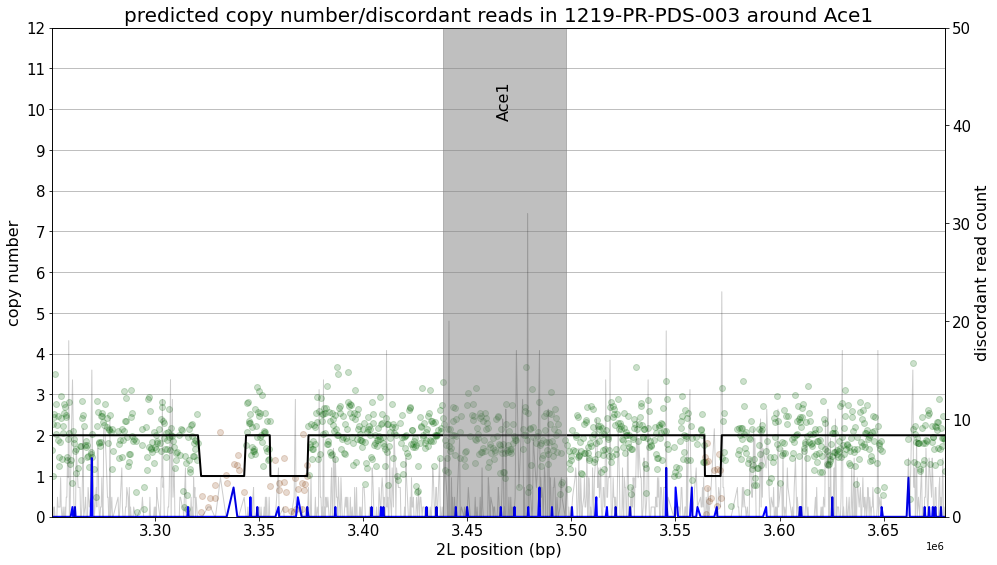

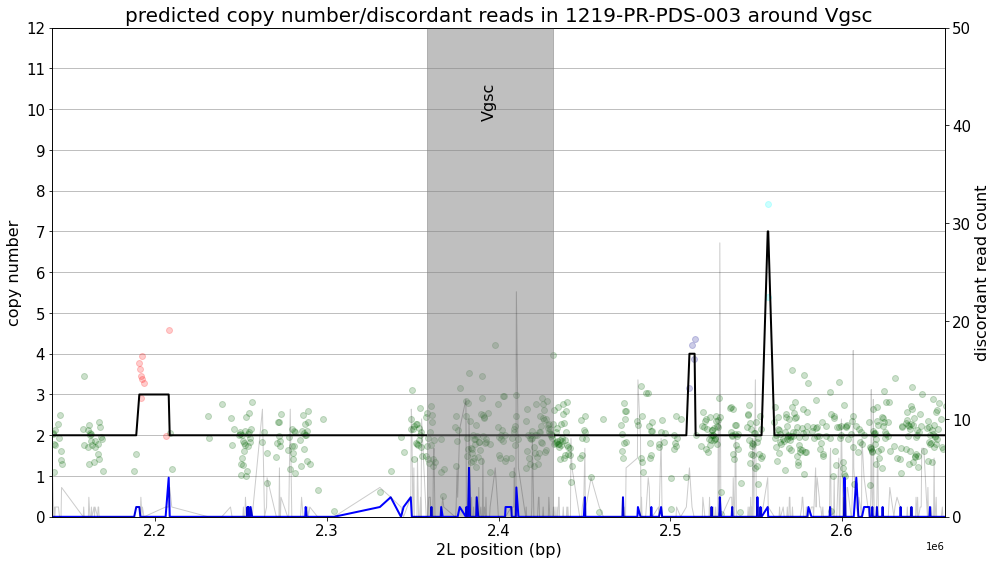

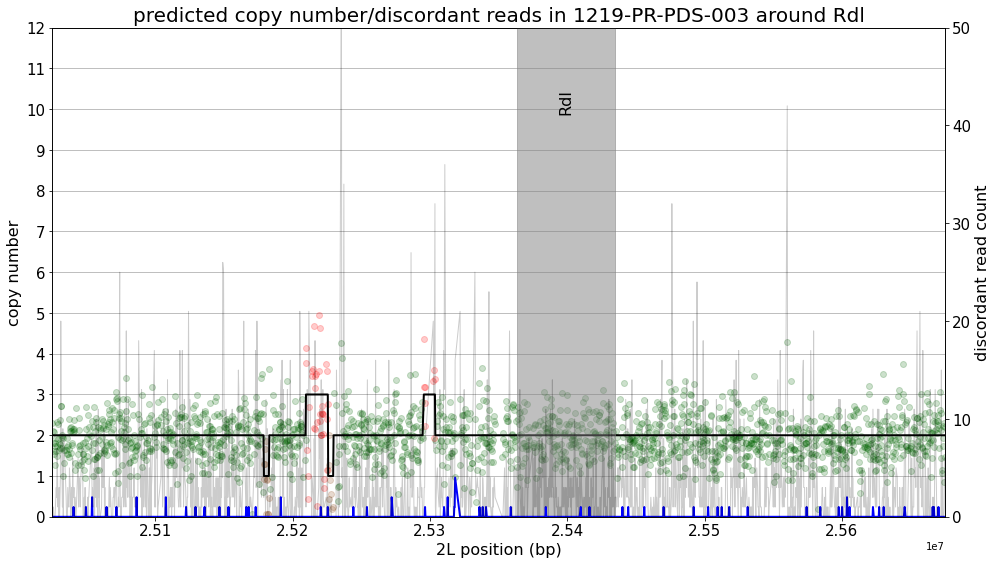

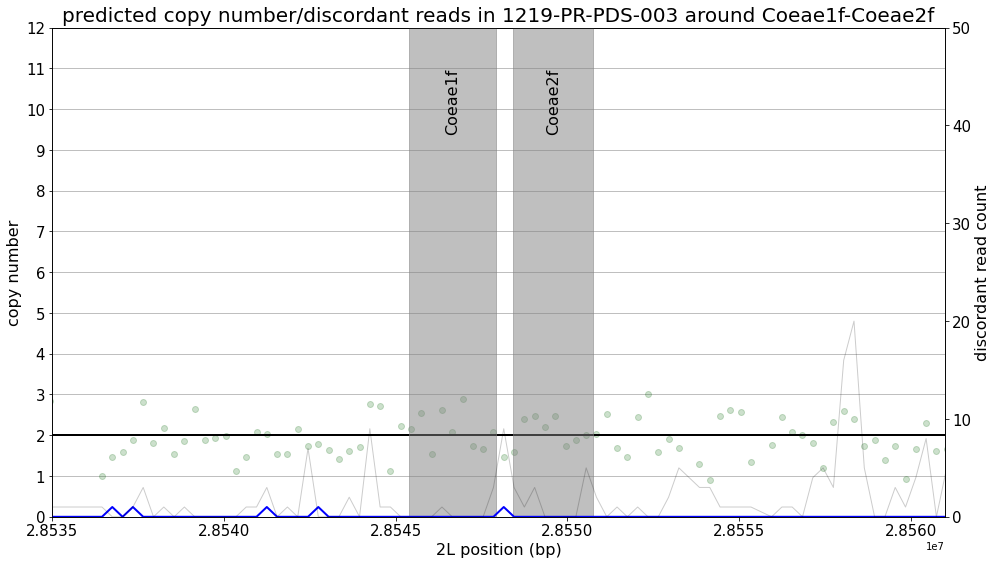

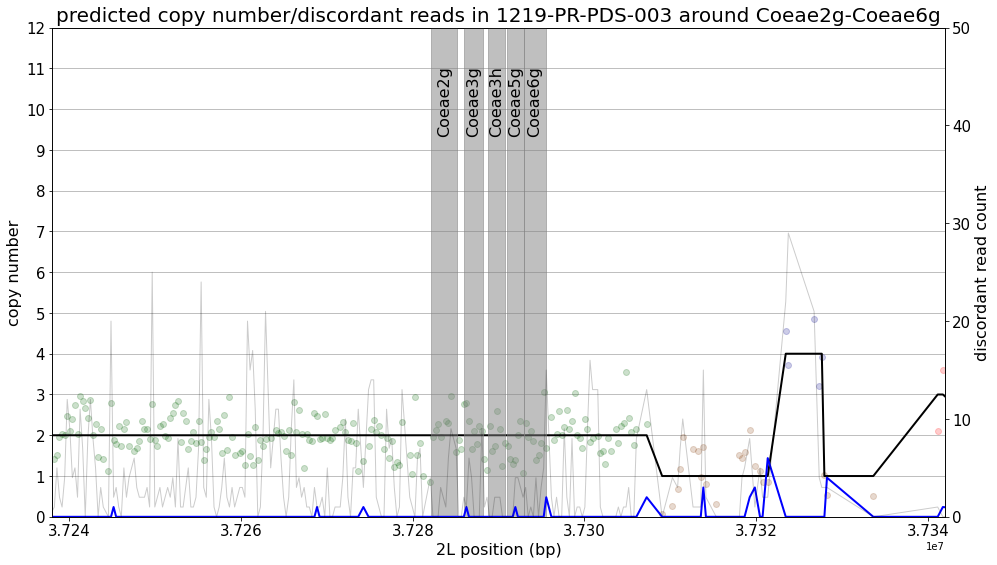

In [71]:
on_chrom = lambda obj: obj.chrom == chromosome # predicate that checks if a Gene/Cluster is on chromosome
for cluster in filter(on_chrom, clusters): # selects only clusters on chromosome
    fig = plt.figure(figsize=(16, 9))
    ax = fig.add_subplot(111)
    ax.set_title(f"predicted copy number/discordant reads in {sample_name} around {cluster.name}", fontsize=20)
    ax.set_xlabel(f"{chromosome} position (bp)", fontsize=16)
    ax.set_ylabel("copy number", fontsize=16)
    cluster_len = cluster.end - cluster.start
    # sets limits to be slightly larger than cluster length
    ax.set_xlim(left=cluster.start - int(cluster_len*0.15), right=cluster.end + int(cluster_len*0.15))
    ax.tick_params(labelsize=15)
    ax.set_ylim(bottom=0, top=12)
    ax.grid(axis='y')
    ax.set_yticks(range(13))
    for i, color in zip(range(13), COLORS):
        ax.plot(filtered_pos[copy_number == i], 
                filtered_depth[copy_number == i], 
                color=color, marker='o', linestyle=' ', alpha=0.2)
    ax.plot(filtered_pos, copy_number, linestyle='-', linewidth=2, color='k')
    ax_alt = ax.twinx()
    ax_alt.set_ylabel("discordant read count", fontsize=16)
    ax_alt.tick_params(labelsize=15)
    ax_alt.plot(filtered_pos, faceaway_count, linestyle='-', linewidth=2, color='b')
    ax_alt.plot(filtered_pos, softclipped_count, linestyle='-', alpha=0.2, linewidth=1, color='k')
    ax_alt.set_ylim(bottom=0, top=50)
    # sets the fontsize for all gene labels in the cluster
    gene_fontsize = min(min([700*(g.end - g.start) / cluster_len for g in cluster.genes]), 16) 
    for i, gene in enumerate(cluster.genes):
        plt.axvspan(gene.start, gene.end, color="#808080", alpha=0.5) # highlights individual genes.
        gene_midpoint = (gene.end + gene.start) // 2
        # label individual genes
        transform = matplotlib.transforms.blended_transform_factory(ax.transData, ax.transAxes)
        plt.text(x=gene_midpoint, y=0.85, s=gene.name, transform=transform,
                 verticalalignment = "center", horizontalalignment="center", rotation="vertical", fontsize=gene_fontsize)
        plt.savefig(f"img_{cluster.name}.png")

In [62]:
whole_coverage[chromosome].dtype.names

('chrom',
 'pos',
 'gc',
 'reads_all',
 'reads_pp',
 'reads_mate_unmapped',
 'reads_mate_other_chr',
 'reads_mate_same_strand',
 'reads_faceaway',
 'reads_softclipped',
 'reads_duplicate',
 'reference_gc',
 'accessible',
 'depth_normed',
 'filtered')

In [18]:
whole_coverage[chromosome][94933]

(b'2L', 28480050, 38, 36, 28, 0, 8, 0, 0, 6, 7, 38, True, 2.02176572, False)

In [19]:
28480150 // 300

94933